<a href="https://colab.research.google.com/github/Alf-caput/NonVerbalAudioClassifier/blob/dev2/src/tensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

zip_filename = 'vs_release_16k.zip'

if not os.path.exists(zip_filename):
    os.system("wget https://www.dropbox.com/s/fuld3z222j9t1oy/vs_release_16k.zip")

Dentro de vs_release_16k.zip descomprimimos:  
- audio_16k  

Nos servimos del módulo zipfile para descomprimir.  

In [ ]:
import os
from zipfile import ZipFile
from concurrent.futures import ThreadPoolExecutor

audio_dir = 'audio_16k/'

if not os.path.exists(audio_dir):
    with ZipFile(zip_filename, 'r') as zf:
        with ThreadPoolExecutor() as exe:
            for file in zf.namelist():
                if file.startswith(audio_dir):
                    exe.submit(zf.extract, file)

In [ ]:
import tensorflow as tf

audio_dir = 'audio_16k/'
seed = 42

tf.random.set_seed(seed)

filenames = tf.io.gfile.glob(audio_dir + '*')
filenames = tf.random.shuffle(filenames, seed)

print('Total audios:', len(filenames))
print('Example:', filenames.shape)

Total audios: 21024
Example: (21024,)


In [ ]:
vocal_sounds = ['cough', 'laughter', 'sigh', 'sneeze', 'sniff', 'throatclearing']
num_sounds = len(vocal_sounds)

test_file = filenames[0]
def get_label(file_path):
  label = tf.strings.split(
    input=file_path,
    sep='_')[-1]

  label = tf.strings.split(
    input=label,
    sep='.')[0]

  label = tf.where(label==vocal_sounds)
  label = tf.reshape(label, ())
  return label

get_label(test_file), test_file

(<tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'audio_16k/f1001_0_sneeze.wav'>)

In [ ]:
std_len = 64000
def get_signal(file_path):
  audio_binary = tf.io.read_file(file_path)
  signal = tf.audio.decode_wav(audio_binary)[0]
  signal = signal[:std_len]
  signal = tf.pad(signal, [[0, std_len-len(signal)], [0, 0]])
  return tf.squeeze(signal, axis=-1)

get_signal(test_file), test_file

(<tf.Tensor: shape=(64000,), dtype=float32, numpy=
 array([-1.2207031e-04, -9.1552734e-05, -3.0517578e-05, ...,
        -1.2207031e-04, -6.1035156e-05, -9.1552734e-05], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'audio_16k/f1001_0_sneeze.wav'>)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
ds_files = tf.data.Dataset.from_tensor_slices(filenames)
ds_signals = ds_files.map(lambda x: (get_signal(x), get_label(x)), num_parallel_calls=AUTOTUNE)
ds_files.element_spec, ds_signals.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 (TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)))

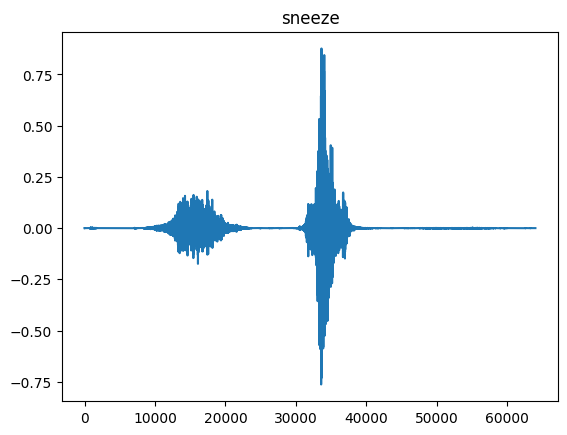

In [ ]:
import matplotlib.pyplot as plt
for elem in ds_signals.take(1):
  signal, label = elem
  plt.plot(signal)
  plt.title(vocal_sounds[label])

In [ ]:
def remove_shortaudio(filename):
  if get_signal(filename).shape[0] < min_len:
    tf.io.gfile.remove(filename)

initial_file_count = 21024

if len(filenames) >= initial_file_count:
  # Remove less than 0.1s audios (16kHz then 1600 frames)
  min_len = 1600
  with ThreadPoolExecutor() as exe:
    for file in filenames:
      exe.submit(remove_shortaudio, file)

  filenames = tf.io.gfile.glob(audio_dir + '*')

print('Total audios:', len(filenames))


Total audios: 21024


In [ ]:
ds_files = tf.data.Dataset.from_tensor_slices(filenames)
ds_signals = ds_files.map(lambda x: (get_signal(x), get_label(x)), num_parallel_calls=AUTOTUNE)

In [ ]:
for elem in ds_signals.take(1):
  print(elem)

(<tf.Tensor: shape=(64000,), dtype=float32, numpy=
array([-3.0517578e-05,  3.0517578e-05,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [ ]:
def normalize(audio, label):
  label = tf.one_hot(label, len(vocal_sounds))
  return audio, label

ds_signals = ds_signals.map(normalize).cache()

In [ ]:
for elem in ds_signals.take(1):
  print(elem)

(<tf.Tensor: shape=(64000,), dtype=float32, numpy=
array([-3.0517578e-05,  3.0517578e-05,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)>, <tf.Tensor: shape=(6,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0.], dtype=float32)>)


In [ ]:
ds_signals.element_spec

(TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 TensorSpec(shape=(6,), dtype=tf.float32, name=None))

In [ ]:
num_train = len(ds_signals)

RATIO = 0.2
test_size = int(RATIO * num_train)

ds_train = ds_signals.skip(test_size)
ds_test = ds_signals.take(test_size)

In [ ]:
num_train = len(ds_train)

RATIO = 0.2
validation_size = int(RATIO * num_train)

ds_fit = ds_signals.skip(validation_size)
ds_val = ds_signals.take(validation_size)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 1024
ds_fit = (
    ds_fit
    .cache()
    .shuffle(len(ds_fit))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

ds_val = (
    ds_val
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.0001)

epoch_wait = 5
# Crear el EarlyStopping callback con la función on_train_end
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=epoch_wait)

# Definimos los callbacks
callbacks = [early_stopping, reduce_lr]

In [ ]:
# Establecer la semilla global
seed_value = 42
tf.random.set_seed(seed_value)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Arquitectura de la red convolucional
model = Sequential([
    Dense(64, activation='relu', input_shape=(64000,)),  # Capa de entrada con 64 neuronas
    Dense(32, activation='relu'),  # Capa oculta con 32 neuronas
    Dense(6, activation='sigmoid')  # Capa de salida con una neurona para clasificación binaria
])

# Compila el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Resumen de la arquitectura del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                4096064   
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 6)                 198       
                                                                 
Total params: 4098342 (15.63 MB)
Trainable params: 4098342 (15.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(ds_fit, epochs=100, validation_data=ds_val, callbacks=callbacks)

Epoch 1/100
18/18 [==============================] - 58s 350ms/step - loss: 0.6633 - accuracy: 0.1754 - val_loss: 0.6180 - val_accuracy: 0.1778 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 4s 227ms/step - loss: 0.4994 - accuracy: 0.4534 - val_loss: 0.5420 - val_accuracy: 0.1837 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 6s 340ms/step - loss: 0.3891 - accuracy: 0.5998 - val_loss: 0.5194 - val_accuracy: 0.1855 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 4s 220ms/step - loss: 0.3058 - accuracy: 0.7141 - val_loss: 0.5253 - val_accuracy: 0.2042 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 5s 254ms/step - loss: 0.2364 - accuracy: 0.8309 - val_loss: 0.5450 - val_accuracy: 0.2310 - lr: 0.0010
Epoch 6/100
18/18 [==============================] - 8s 446ms/step - loss: 0.1792 - accuracy: 0.8934 - val_loss: 0.5772 - val_accuracy: 0.2393 - lr: 0.0010
Epoch 7/100
18/18 [==============================] - 5s 243ms/s

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Arquitectura de la red convolucional
model = Sequential([
    Dense(1024, activation='relu', input_shape=(64000,)),  # Capa de entrada con 1024 neuronas
    Dense(512, activation='relu'),  # Capa oculta con 512 neuronas
    Dense(512, activation='relu'),  # Capa oculta con 512 neuronas
    Dense(6, activation='sigmoid')  # Capa de salida con una neurona para clasificación binaria
])

# Compila el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Resumen de la arquitectura del modelo
model.summary()

history = model.fit(ds_fit, epochs=100, validation_data=ds_val, callbacks=callbacks)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1024)              65537024  
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dense_8 (Dense)             (None, 512)               262656    
                                                                 
 dense_9 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 66327558 (253.02 MB)
Trainable params: 66327558 (253.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
18/18 [==============================] - 8s 367ms/step - loss: 0.5389 - accuracy: 0.1727 - val_loss: 0.5055 - val_accuracy: 0.1825

In [ ]:
BATCH_SIZE = 128
ds_eval = (
    ds_test.cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
test_loss, test_acc = model.evaluate(ds_eval)

print('Test accuracy:', test_acc)

33/33 [==============================] - 1s 22ms/step - loss: 1.1692 - accuracy: 0.3865
Test accuracy: 0.3865366280078888
